# Описание

Эта часть общей работы основана на статье "ANOMALY DETECTION IN UNIVARIATE TIME-SERIES: A
SURVEY ON THE STATE-OF-THE-ART" (https://arxiv.org/pdf/2004.00433.pdf).

An anomaly is an observation or a sequence of observations which deviates remarkably from the
general distribution of data. Поиском таких наблюдений мы дальше и будем заниматься, рассматривая датасет дневной доходности SNGS с 2015 года.

Anomaly detection является полезным в различных случаях. Например, нахождение аномалий в нашем случае может быть полезно для риск-менеджмента: будут анализироваться причины найденных аномалий, которые будут учитываться при выставлении риск-параметров. Помимо этого, регуляторы могут считать аномалии симптоном манипуляций рынком.

Будем использовать метод Local Outlier Factor (LOF) для поиска аномалий. По просту говоря, LOF - это kNN на максималках (учитывает дополнительно плотность объектов, рассчитывая "под капотом" помимо обычного расстояния другие метрики). Более подробное описание метода можно найти в статье.

# Библиотеки

In [583]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

from sklearn.neighbors import LocalOutlierFactor

# Подготовка данных

In [459]:
df = pd.read_csv('df_r.csv')
data = np.array(df['SNGS'])

Ранее было замечено, что в районе 400 наблюдения имеется пологий участок. Это связано с особенностями проведеня торгов на фондовом рынке в феврале-марте.

# Деление на тест и трейн

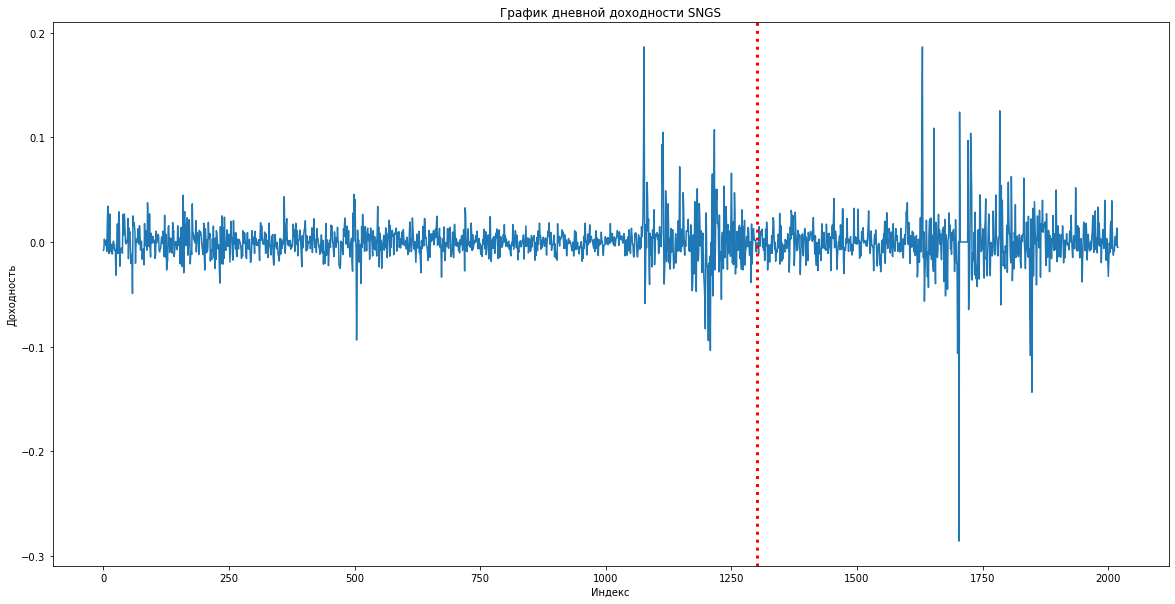

In [591]:
plt.figure(figsize = (20, 10))
plt.title('График дневной доходности SNGS')
plt.xlabel('Индекс')
plt.ylabel('Доходность')
plt.plot(data)
plt.axvline(1300, color='red', linestyle='dotted', linewidth=3)

Чтобы адекватно подбрать параметры, а затем оценить модель, трейн и тест должны включаnь нормальные и аномальные данные.

Трейн будет идти до 1300 индекса включительно, а после тест. Таким образом мы включим в них нормальные и аномальные участки.

In [461]:
train = data[:1301]

In [462]:
test = data[1301:]

# Разметка данных

Размечать данные будем методом, основанном на IQR. Более конкретно: будем считать аномалиями те точки, значения которых больше q2 + 1.5 * IQR или меньше q1 - 1.5 * IQR (где q2 - 0.75 квантиль, q1 - 0.25 квантиль, iqr - интерквартильный размах). (для подробностей см. https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097)

#### Разметим трейн

In [463]:
q1_tr = np.quantile(train, 0.25)
q2_tr = np.quantile(train, 0.75)
iqr_tr = q2_tr - q1_tr
lower_tr = q1_tr - 1.5*iqr_tr
upper_tr = q2_tr + 1.5*iqr_tr
ind_tr = np.where((train > upper_tr) | (train < lower_tr))[0]

In [481]:
real_tr = train.copy()
real_tr[ind_tr] = -1
real_tr[list(set(np.arange(0, 1301)) - set(ind_tr))] = 1

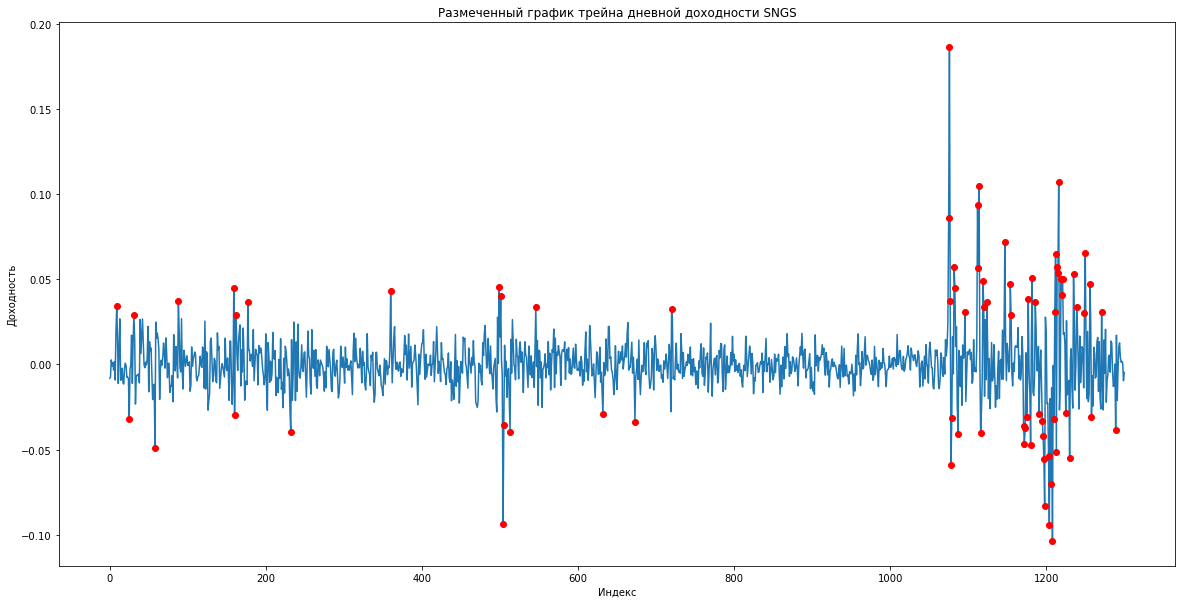

In [465]:
plt.figure(figsize = (20, 10))
plt.title('Размеченный график трейна дневной доходности SNGS')
plt.xlabel('Индекс')
plt.ylabel('Доходность')
plt.plot(train)
plt.plot(ind_tr, train[ind_tr], 'ro')

#### Разметим тест

In [414]:
q1_te = np.quantile(test, 0.25)
q2_te = np.quantile(test, 0.75)
iqr_te = q2_te - q1_te
lower_te = q1_te - 1.5*iqr_te
upper_te = q2_te + 1.5*iqr_te
ind_te = np.where((test > upper_te) | (test < lower_te))[0]

In [559]:
real_te = test.copy()
real_te[ind_te] = -1
real_te[list(set(np.arange(0, len(real_te))) - set(ind_te))] = 1

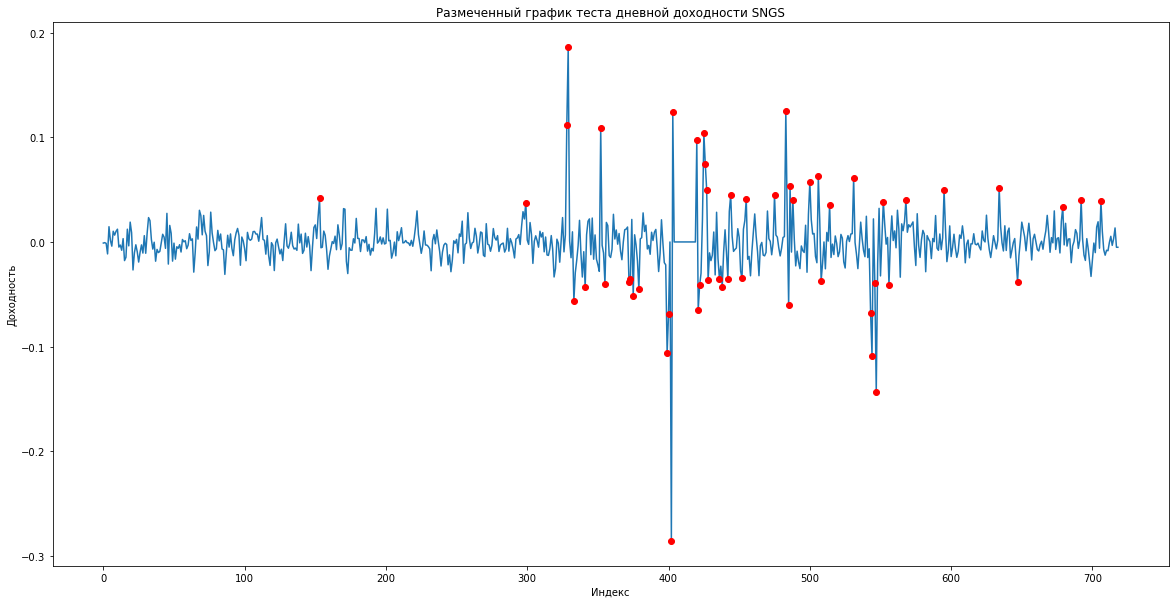

In [416]:
plt.figure(figsize = (20, 10))
plt.title('Размеченный график теста дневной доходности SNGS')
plt.xlabel('Индекс')
plt.ylabel('Доходность')
plt.plot(test)
plt.plot(ind_te, test[ind_te], 'ro')

# Подбор гиперпараметров

Для LOF необходимо подобрать число соседей, будем использовать F1 метрику для оценки качества. Так как данных не очень много, можно пройтись и циклом.

In [569]:
train = train.reshape(-1, 1)

In [570]:
f1_s = []
for n in np.arange(1, 300):
    clf = LocalOutlierFactor(n_neighbors = n)
    pred = clf.fit_predict(train)
    f1_s.append((f1_score(real_tr, pred), n))

In [571]:
f1_s.sort(reverse = True)
f1_s[0:5]

[(0.9983700081499592, 65),
 (0.9983700081499592, 64),
 (0.997557003257329, 63),
 (0.9975530179445351, 66),
 (0.9971509971509972, 62)]

In [572]:
clf = LocalOutlierFactor(n_neighbors = 65)

In [573]:
pred = clf.fit_predict(train)

Аномалия найдена 2015-06-16 и составила 0.0341813641329797
Аномалия найдена 2015-07-08 и составила -0.031787874089006
Аномалия найдена 2015-07-16 и составила 0.02882797731569
Аномалия найдена 2015-08-24 и составила -0.0492926284437826
Аномалия найдена 2015-10-05 и составила 0.0375150060024009
Аномалия найдена 2016-01-19 и составила 0.0446333687566418
Аномалия найдена 2016-01-22 и составила 0.0288475618685019
Аномалия найдена 2016-02-12 и составила 0.0364496382860323
Аномалия найдена 2016-05-04 и составила -0.0393712143063167
Аномалия найдена 2016-11-02 и составила 0.043207616257781
Аномалия найдена 2017-05-25 и составила 0.0454957404386441
Аномалия найдена 2017-05-29 и составила 0.0404367855314792
Аномалия найдена 2017-06-01 и составила -0.0937808489634748
Аномалия найдена 2017-06-02 и составила -0.0357661583151779
Аномалия найдена 2017-06-15 и составила -0.0396700706991359
Аномалия найдена 2017-08-01 и составила 0.0339787395596051
Аномалия найдена 2018-01-31 и составила -0.03359130577

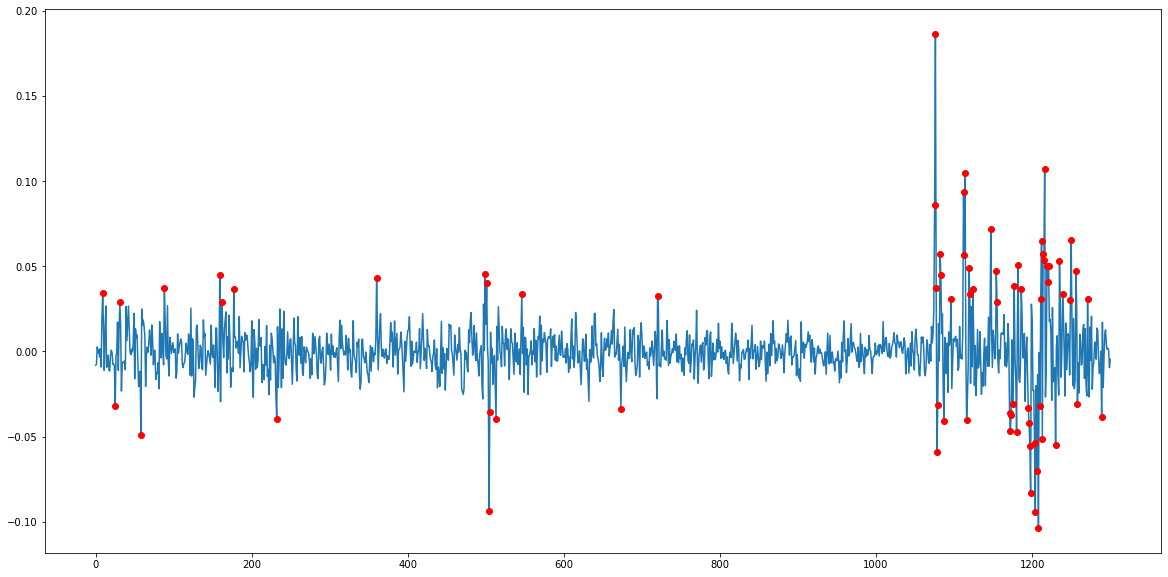

In [576]:
plt.figure(figsize = (20, 10))
plt.plot(train)
plt.plot(np.where(pred == -1)[0], train[np.where(pred == -1)[0]], 'ro')
for i in np.where(pred == -1)[0]:
    print('Аномалия найдена', df['Дата торгов'].iloc[i], 'и составила', df['SNGS'].iloc[i])

In [575]:
print('F1 метрика составила', f1_score(real_tr, pred))

F1 метрика составила 0.9983700081499592


Отлично!

# Тестирование

In [578]:
test = test.reshape(-1, 1)

In [579]:
clf = LocalOutlierFactor(n_neighbors = 65)

In [580]:
pred = clf.fit_predict(test)

Аномалия найдена 2021-03-09 и составила 0.041534008683068
Аномалия найдена 2021-09-30 и составила 0.0376282782212086
Аномалия найдена 2021-11-11 и составила 0.1118430683648075
Аномалия найдена 2021-11-12 и составила 0.1864384463462804
Аномалия найдена 2021-11-18 и составила -0.0566395361801761
Аномалия найдена 2021-11-30 и составила -0.0433942827710531
Аномалия найдена 2021-12-15 и составила 0.1087642298724455
Аномалия найдена 2021-12-20 и составила -0.0398846105606422
Аномалия найдена 2022-01-13 и составила -0.037873180360227
Аномалия найдена 2022-01-14 и составила -0.0350044877548402
Аномалия найдена 2022-01-18 и составила -0.0516389177939646
Аномалия найдена 2022-01-24 и составила -0.0452205370808404
Аномалия найдена 2022-02-21 и составила -0.1064262867112532
Аномалия найдена 2022-02-22 и составила -0.0691506671005532
Аномалия найдена 2022-02-24 и составила -0.2859639923090368
Аномалия найдена 2022-02-25 и составила 0.1241126070991432
Аномалия найдена 2022-03-24 и составила 0.097125

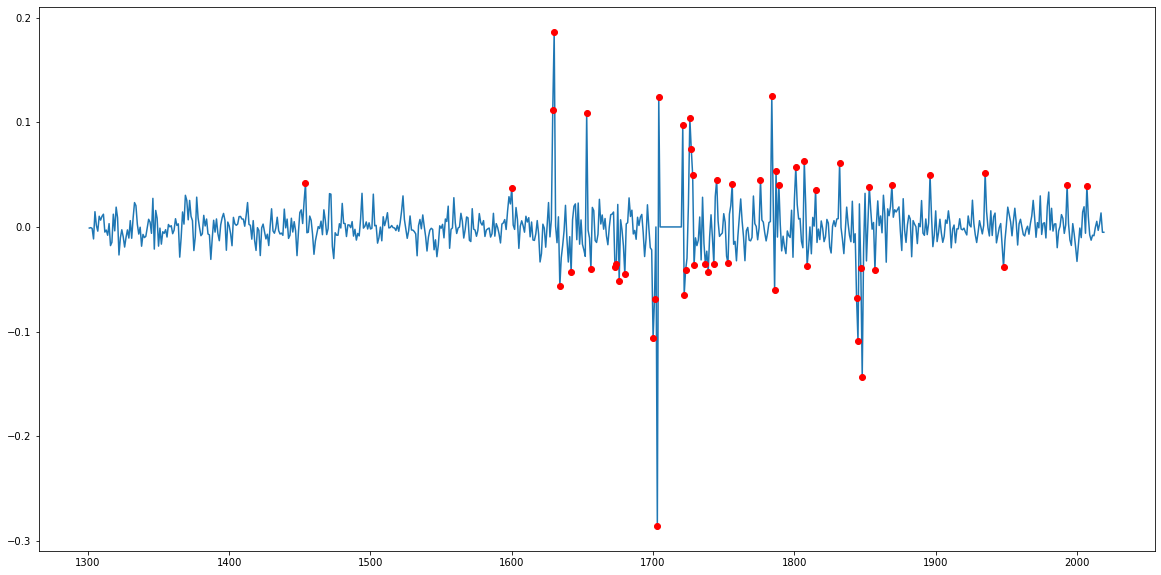

In [581]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(1301, 2020), test)
plt.plot(np.where(pred == -1)[0]+1301, test[np.where(pred == -1)[0]], 'ro')
for i in np.where(pred == -1)[0]+1301:
    print('Аномалия найдена', df['Дата торгов'].iloc[i], 'и составила', df['SNGS'].iloc[i])


In [582]:
print('F1 метрика составила', f1_score(real_te, pred))

F1 метрика составила 0.9992509363295881


Прекрасный результат!
